# Multiclass classification with confocal data
- The -30, -25, ... 0 ..., 25, 30 micron z-stack (1024,1024) of A594 cells (cy5) was taken in confocal system
- Multiclass classification was used to train this data
- We used half labels (positive distance) total 7 labels
## EDITED VERSION BECAUSE WE CALLED WRONG IMAGES
We use 256x256 pixels (h=256)
- Both layers have batchnorm() like V11 but with different size of maxpooling



In [2]:
# -*- coding: utf-8 -*-
"""
Created on Mon Feb  8 10:43:10 2021

@author: Peach
"""
import numpy as np 
import os
import cv2 
import matplotlib.pyplot as plt
import keras
import time
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from keras import regularizers
import pickle
import collections
from sklearn.metrics import mean_squared_error
from tensorflow.keras import regularizers

from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, BatchNormalization, Activation
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.constraints import maxnorm


#%% include half of images in pos focus direction (total is 7 labels)
mainfolder = 'F:/JB/2.Focus_zstepof 5 micron/'
x = []
y=[]
h=256
for subfolder in os.listdir(mainfolder):
    sub_dir_path = mainfolder + subfolder
    img_name_list = os.listdir(sub_dir_path)
    img_name_list.sort()
    for img_name in img_name_list:
        if img_name[-3::] == "tif":
            #print(img_name[-3::])
            z = img_name[-6:-4]
            #print(z)
            if z[-2] is 'p' and int(z[-1]) < 7:
                n = int(z[-1])
                stackn = n
                img = cv2.imread(os.path.join(sub_dir_path,img_name),-1)
                imgResize = cv2.resize(img, (h, h))
                imgResize = np.array(imgResize)
                imgResize = preprocessing.scale(imgResize)
                #print(imgResize.std())
                #print(imgResize.mean())
                imgResize = imgResize.reshape(h,h,1)
                x.append(imgResize) 
                y.append(stackn)
x=np.array(x)
y=np.array(y) 

<>:41: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:41: SyntaxWarning: "is" with a literal. Did you mean "=="?
<ipython-input-2-fc30a4a3197a>:41: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if z[-2] is 'p' and int(z[-1]) < 7:


In [4]:
#create model
model= Sequential()
model.add(Conv2D(32, (3, 3), strides = (2, 2), input_shape=(h, h, 1), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(5, 5)))
model.add(Conv2D(64, (3, 3), strides = (2, 2), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(5, 5)))
model.add(Dropout(0.2))
model.add(Flatten())
model.add(Dense(256, activation='relu', kernel_regularizer=regularizers.l1_l2(l1=1e-3, l2=1e-1)))
model.add(Dense(64, activation='relu'))
model.add(Dense(7, activation='softmax'))
model.compile(optimizer=keras.optimizers.SGD(lr = 0.01), 
              loss='sparse_categorical_crossentropy', 
              metrics = ['acc'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 127, 127, 32)      320       
_________________________________________________________________
batch_normalization_2 (Batch (None, 127, 127, 32)      128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 25, 25, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 12, 12, 64)        18496     
_________________________________________________________________
batch_normalization_3 (Batch (None, 12, 12, 64)        256       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 2, 2, 64)          0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 2, 2, 64)         

In [5]:
#%%
#split and shuffle the data
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=55)
X_train, X_val, y_train, y_val  = train_test_split(X_train, y_train, test_size=0.1, random_state=45)

In [6]:
#%% fit model
result = model.fit(X_train, y_train, validation_data=(X_test,y_test), epochs =80, batch_size = 64)

Epoch 1/80
58/58 [==============================] - 37s 626ms/step - loss: 29.4563 - acc: 0.2756 - val_loss: 24.9676 - val_acc: 0.2483
Epoch 2/80
58/58 [==============================] - 34s 592ms/step - loss: 23.1457 - acc: 0.4108 - val_loss: 20.0991 - val_acc: 0.3196
Epoch 3/80
58/58 [==============================] - 34s 591ms/step - loss: 18.4270 - acc: 0.5031 - val_loss: 16.1418 - val_acc: 0.4076
Epoch 4/80
58/58 [==============================] - 34s 593ms/step - loss: 14.7229 - acc: 0.5256 - val_loss: 12.9470 - val_acc: 0.4643
Epoch 5/80
58/58 [==============================] - 34s 594ms/step - loss: 11.8210 - acc: 0.5755 - val_loss: 10.4481 - val_acc: 0.4731
Epoch 6/80
58/58 [==============================] - 34s 592ms/step - loss: 9.5392 - acc: 0.5594 - val_loss: 8.3500 - val_acc: 0.5044
Epoch 7/80
58/58 [==============================] - 35s 597ms/step - loss: 7.6898 - acc: 0.5985 - val_loss: 6.8346 - val_acc: 0.4761
Epoch 8/80
58/58 [==============================] - 34s 594

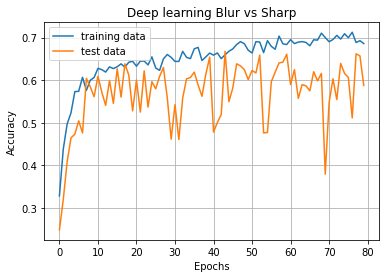

In [7]:
_, ax =plt.subplots()
ax.plot(result.history['acc'])
ax.plot(result.history['val_acc'])
_ = ax.set_xlabel('Epochs')
_ = ax.set_ylabel('Accuracy')
_ = ax.set_title('Deep learning Blur vs Sharp')
_ = ax.legend(["training data", "test data"])
ax.grid()
plt.show()

In [8]:
#model.save('C:/Users/Nette/Desktop/GIS/ImageBasedFocusing/Machine learning save model/ACNNsConfocalblurdetectionmodel1')
filename = 'Confocal_multiclass_model5_7labels_V20.sav'
model.save('F:\JB\Confocal_multiclass_model5_7labels_V21\Model13_edit')

INFO:tensorflow:Assets written to: F:\JB\Confocal_multiclass_model5_7labels_V21\Model13_edit\assets


In [9]:
#Use Model to predict
result = model.predict(X_val)
predicted_classes = result.argmax(axis=1)
real_classes = y_val
difference = np.subtract(real_classes, predicted_classes)
#Count frequencies of all elements in array in Python using collections module
freq = []
freq = collections.Counter(difference) 
for (key, value) in sorted(freq.items()): 
    
    print (key, " -> ", value)

-3  ->  1
-2  ->  7
-1  ->  99
0  ->  250
1  ->  37
2  ->  14
3  ->  1


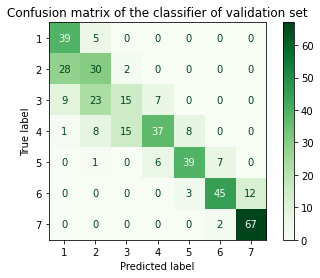

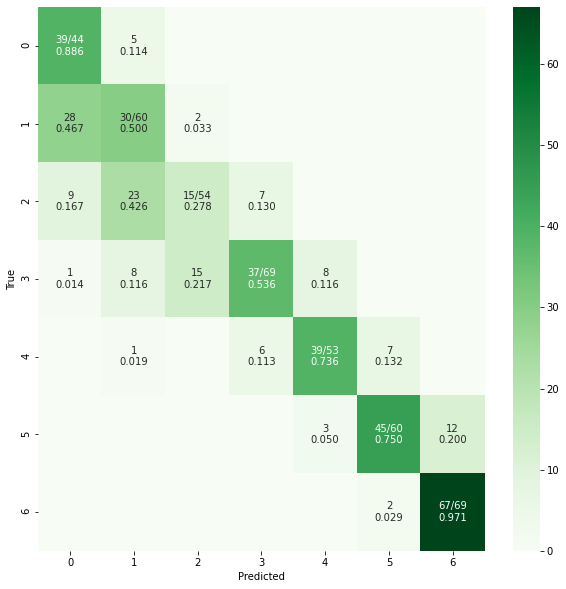

In [16]:
#confusion matrix without normalization (run this one first)
from sklearn.metrics import confusion_matrix
y_pred = model.predict(X_val)
y_pred = y_pred.argmax(axis=1)
y_true = y_val
cm = confusion_matrix(y_true, y_pred) #normalize = 'true'
#cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
from sklearn.metrics import ConfusionMatrixDisplay
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=[1,2,3,4,5,6,7])
disp = disp.plot(include_values=True, cmap='Greens')
plt.title('Confusion matrix of the classifier of validation set')
plt.show()
#confusion matrix with normalization and adjust the size
import pandas as pd
import seaborn as sns
from sklearn.metrics import confusion_matrix

def cm_analysis(y_true, y_pred, labels, ymap=None, figsize=(10,10)):
    """
    Generate matrix plot of confusion matrix with pretty annotations.
    The plot image is saved to disk.
    args: 
      y_true:    true label of the data, with shape (nsamples,)
      y_pred:    prediction of the data, with shape (nsamples,)
      filename:  filename of figure file to save
      labels:    string array, name the order of class labels in the confusion matrix.
                 use `clf.classes_` if using scikit-learn models.
                 with shape (nclass,).
      ymap:      dict: any -> string, length == nclass.
                 if not None, map the labels & ys to more understandable strings.
                 Caution: original y_true, y_pred and labels must align.
      figsize:   the size of the figure plotted.
    """
    if ymap is not None:
        y_pred = [ymap[yi] for yi in y_pred]
        y_true = [ymap[yi] for yi in y_true]
        labels = [ymap[yi] for yi in labels]
    cm = confusion_matrix(y_true, y_pred, labels=labels)
    cmNor = confusion_matrix(y_true, y_pred, labels=labels, normalize='true')
    cm_sum = np.sum(cm, axis=1, keepdims=True)
    #cm_perc = cm / cm_sum.astype(float) * 100
    annot = np.empty_like(cm).astype(str)
    nrows, ncols = cm.shape
    for i in range(nrows):
        for j in range(ncols):
            n = cmNor[i, j]
            c = cm[i, j]
            #p = cm_perc[i, j]
            if i == j:
                s = cm_sum[i]
                annot[i, j] = '%d/%d\n%.3f' % (c, s, n)
            elif c == 0:
                annot[i, j] = ''
            else:
                annot[i, j] = '%d\n%.3f' % (c, n)
    cm = pd.DataFrame(cm, index=labels, columns=labels)
    cm.index.name = 'True'
    cm.columns.name = 'Predicted'
    fig, ax = plt.subplots(figsize=figsize)
    sns.heatmap(cm, annot=annot, cmap='Greens',linecolor='Black', fmt='', ax=ax)
    #plt.savefig(filename)
    plt.show()

    
cm_analysis(y_true, y_pred, [0,1,2,3,4,5,6], ymap=None, figsize=(10,10))

Epoch 1/80
58/58 [==============================] - 38s 660ms/step - loss: 0.7583 - acc: 0.7141 - val_loss: 1.0476 - val_acc: 0.5288
Epoch 2/80
58/58 [==============================] - 37s 642ms/step - loss: 0.7786 - acc: 0.7119 - val_loss: 1.0985 - val_acc: 0.5523
Epoch 3/80
58/58 [==============================] - 37s 630ms/step - loss: 0.7868 - acc: 0.7005 - val_loss: 0.9032 - val_acc: 0.6579
Epoch 4/80
58/58 [==============================] - 36s 620ms/step - loss: 0.7478 - acc: 0.7366 - val_loss: 1.2676 - val_acc: 0.5161
Epoch 5/80
58/58 [==============================] - 37s 637ms/step - loss: 0.7889 - acc: 0.6931 - val_loss: 2.6779 - val_acc: 0.3069
Epoch 6/80
58/58 [==============================] - 37s 635ms/step - loss: 0.8012 - acc: 0.7092 - val_loss: 0.9340 - val_acc: 0.6315
Epoch 7/80
58/58 [==============================] - 36s 623ms/step - loss: 0.7944 - acc: 0.6994 - val_loss: 1.2525 - val_acc: 0.5093
Epoch 8/80
58/58 [==============================] - 36s 622ms/step - 

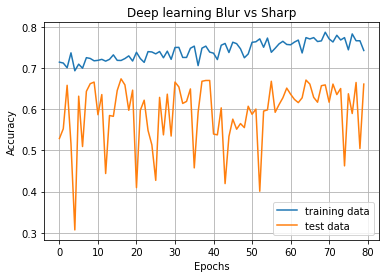

In [10]:
# Continue to fit
result = model.fit(X_train, y_train, validation_data=(X_test,y_test), epochs =80, batch_size = 64)
_, ax =plt.subplots()
ax.plot(result.history['acc'])
ax.plot(result.history['val_acc'])
_ = ax.set_xlabel('Epochs')
_ = ax.set_ylabel('Accuracy')
_ = ax.set_title('Deep learning Blur vs Sharp')
_ = ax.legend(["training data", "test data"])
ax.grid()
plt.show()

In [11]:
#model.save('C:/Users/Nette/Desktop/GIS/ImageBasedFocusing/Machine learning save model/ACNNsConfocalblurdetectionmodel1')
model.save('F:\JB\Confocal_multiclass_model5_7labels_V21\Model13_2_edit')

INFO:tensorflow:Assets written to: F:\JB\Confocal_multiclass_model5_7labels_V21\Model13_2_edit\assets


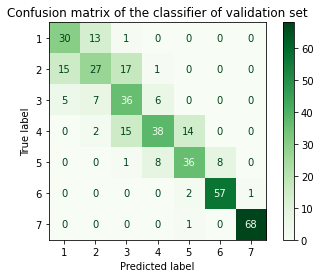

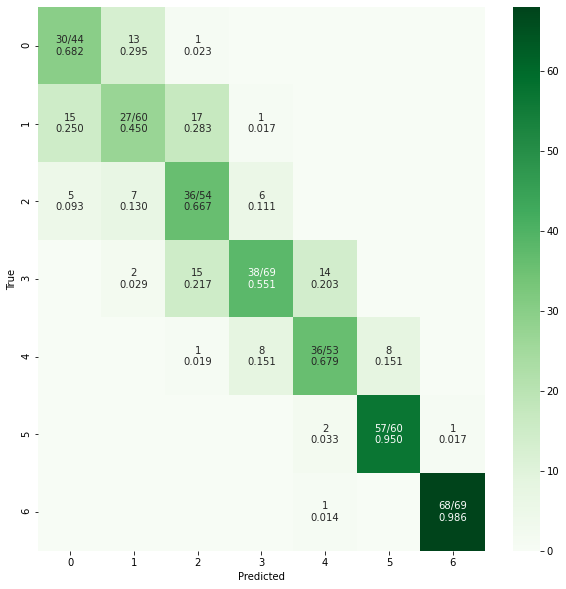

In [12]:
#confusion matrix without normalization (run this one first)
from sklearn.metrics import confusion_matrix
y_pred = model.predict(X_val)
y_pred = y_pred.argmax(axis=1)
y_true = y_val
cm = confusion_matrix(y_true, y_pred) #normalize = 'true'
#cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
from sklearn.metrics import ConfusionMatrixDisplay
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=[1,2,3,4,5,6,7])
disp = disp.plot(include_values=True, cmap='Greens')
plt.title('Confusion matrix of the classifier of validation set')
plt.show()
#confusion matrix with normalization and adjust the size
import pandas as pd
import seaborn as sns
from sklearn.metrics import confusion_matrix

def cm_analysis(y_true, y_pred, labels, ymap=None, figsize=(10,10)):
    """
    Generate matrix plot of confusion matrix with pretty annotations.
    The plot image is saved to disk.
    args: 
      y_true:    true label of the data, with shape (nsamples,)
      y_pred:    prediction of the data, with shape (nsamples,)
      filename:  filename of figure file to save
      labels:    string array, name the order of class labels in the confusion matrix.
                 use `clf.classes_` if using scikit-learn models.
                 with shape (nclass,).
      ymap:      dict: any -> string, length == nclass.
                 if not None, map the labels & ys to more understandable strings.
                 Caution: original y_true, y_pred and labels must align.
      figsize:   the size of the figure plotted.
    """
    if ymap is not None:
        y_pred = [ymap[yi] for yi in y_pred]
        y_true = [ymap[yi] for yi in y_true]
        labels = [ymap[yi] for yi in labels]
    cm = confusion_matrix(y_true, y_pred, labels=labels)
    cmNor = confusion_matrix(y_true, y_pred, labels=labels, normalize='true')
    cm_sum = np.sum(cm, axis=1, keepdims=True)
    #cm_perc = cm / cm_sum.astype(float) * 100
    annot = np.empty_like(cm).astype(str)
    nrows, ncols = cm.shape
    for i in range(nrows):
        for j in range(ncols):
            n = cmNor[i, j]
            c = cm[i, j]
            #p = cm_perc[i, j]
            if i == j:
                s = cm_sum[i]
                annot[i, j] = '%d/%d\n%.3f' % (c, s, n)
            elif c == 0:
                annot[i, j] = ''
            else:
                annot[i, j] = '%d\n%.3f' % (c, n)
    cm = pd.DataFrame(cm, index=labels, columns=labels)
    cm.index.name = 'True'
    cm.columns.name = 'Predicted'
    fig, ax = plt.subplots(figsize=figsize)
    sns.heatmap(cm, annot=annot, cmap='Greens',linecolor='Black', fmt='', ax=ax)
    #plt.savefig(filename)
    plt.show()

    
cm_analysis(y_true, y_pred, [0,1,2,3,4,5,6], ymap=None, figsize=(10,10))